<a href="https://colab.research.google.com/github/gagarcia/COVID-19/blob/master/death_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm

In [0]:
deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [0]:
deaths.set_index('Country/Region',inplace = True)

In [0]:
confirmed.set_index('Country/Region',inplace = True)

In [0]:
deaths_clean = deaths.drop(['Province/State','Lat','Long'],axis=1)
confirmed_clean = confirmed.drop(['Province/State','Lat','Long'],axis=1)

In [0]:
deaths_clean.index.name = None
confirmed_clean.index.name = None

In [0]:
deaths_clean = deaths_clean.transpose()
confirmed_clean = confirmed_clean.transpose()

In [0]:
deaths_clean.index = pd.to_datetime(deaths_clean.index, format='%m/%d/%y')
confirmed_clean.index = pd.to_datetime(confirmed_clean.index, format='%m/%d/%y')

In [23]:
confirmed_clean['Brazil'].tail()

2020-05-15    220291
2020-05-16    233511
2020-05-17    241080
2020-05-18    255368
2020-05-19    271885
Name: Brazil, dtype: int64

In [0]:
Brazil = pd.concat([confirmed_clean['Brazil'],deaths_clean['Brazil']],axis=1)
Brazil.columns = ['Brazil Confirmed', 'Brazil Deaths']

Evolução da dença em escala linear, abaixo vou plotar em escala log pra vermos se a evolução ja saiu de uma exponencial

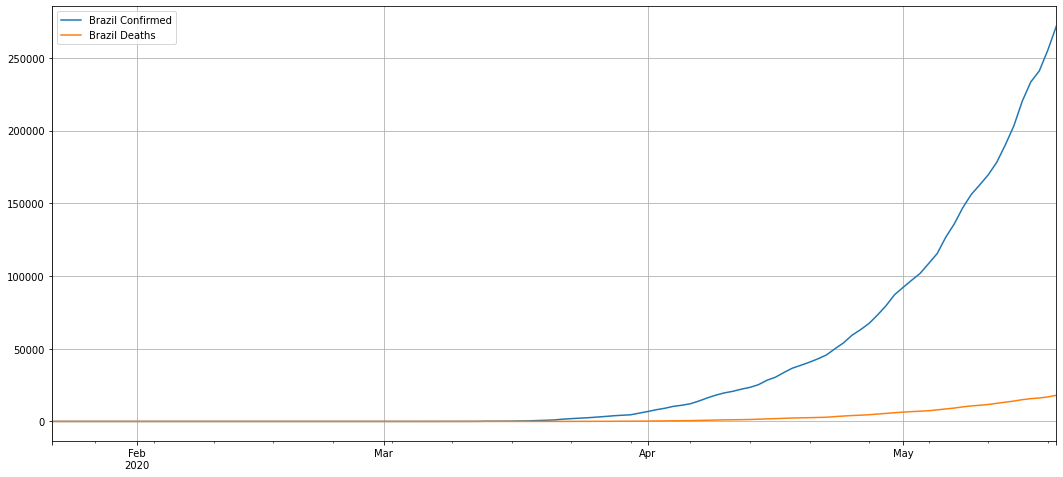

In [25]:
Brazil.plot(figsize=(18,8), grid=True)

Plot em escala LOG

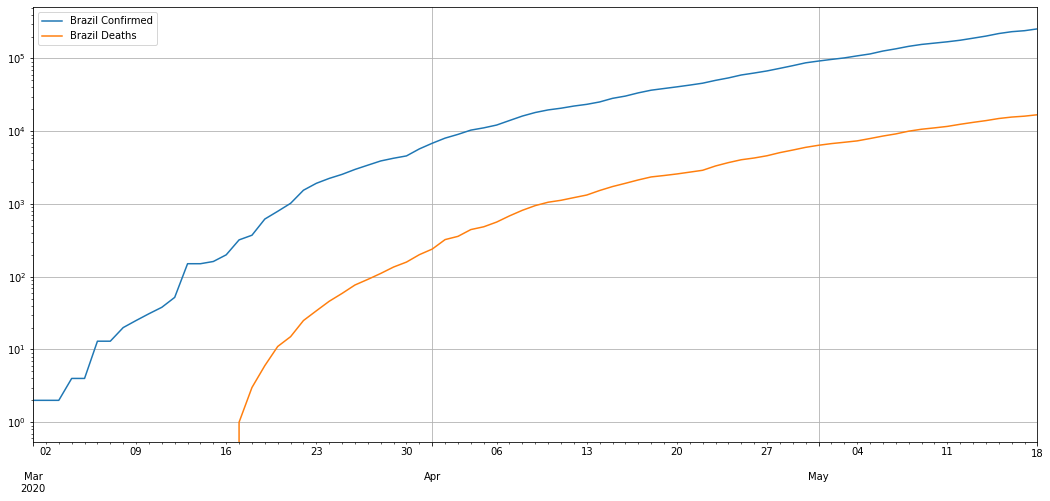

In [26]:
Brazil[['Brazil Confirmed','Brazil Deaths']].plot(figsize=(18,8), grid=True,logy=True,xlim=['2020-03-01','2020-05-18'])

In [27]:
Brazil.tail()

,Brazil Confirmed,Brazil Deaths
2020-05-15,220291,14962
2020-05-16,233511,15662
2020-05-17,241080,16118
2020-05-18,255368,16853
2020-05-19,271885,17983


In [28]:
Brazil['First Difference Confirmed'] = Brazil['Brazil Confirmed'] - Brazil['Brazil Confirmed'].shift(1)
Brazil['First Difference Deaths'] = Brazil['Brazil Deaths'] - Brazil['Brazil Deaths'].shift(1)
Brazil.tail()

,Brazil Confirmed,Brazil Deaths,First Difference Confirmed,First Difference Deaths
2020-05-15,220291,14962,17126.0,963.0
2020-05-16,233511,15662,13220.0,700.0
2020-05-17,241080,16118,7569.0,456.0
2020-05-18,255368,16853,14288.0,735.0
2020-05-19,271885,17983,16517.0,1130.0


**Novos casos por dia**

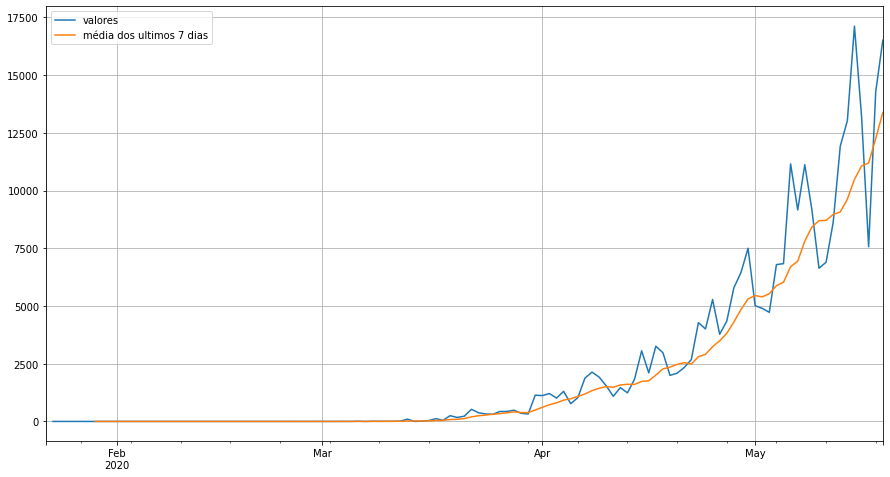

In [29]:
Brazil['First Difference Confirmed'].plot(figsize=(15,8),label = 'valores')
Brazil['First Difference Confirmed'].rolling(7).mean().plot(grid=True,label = 'média dos ultimos 7 dias')
plt.legend()

**Mortes por dia**

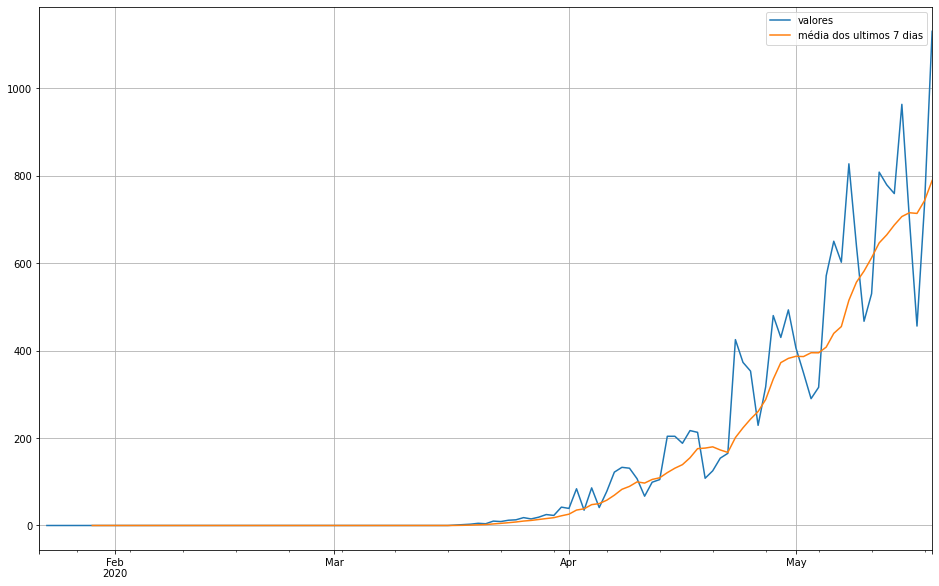

In [30]:
Brazil['First Difference Deaths'].plot(label = 'valores')
Brazil['First Difference Deaths'].rolling(window=7).mean().plot(grid=True,label = 'média dos ultimos 7 dias', figsize=(16,10))
plt.legend()

In [0]:
from pandas.plotting import scatter_matrix

In [0]:
Brazil['Letalidade'] = Brazil['Brazil Deaths']*100/Brazil['Brazil Confirmed']

Nos graficos de Deaths vs Confirmed parace existir uma linearidade, indicando que os sistemas de saude ainda não estão sobrecarregados.

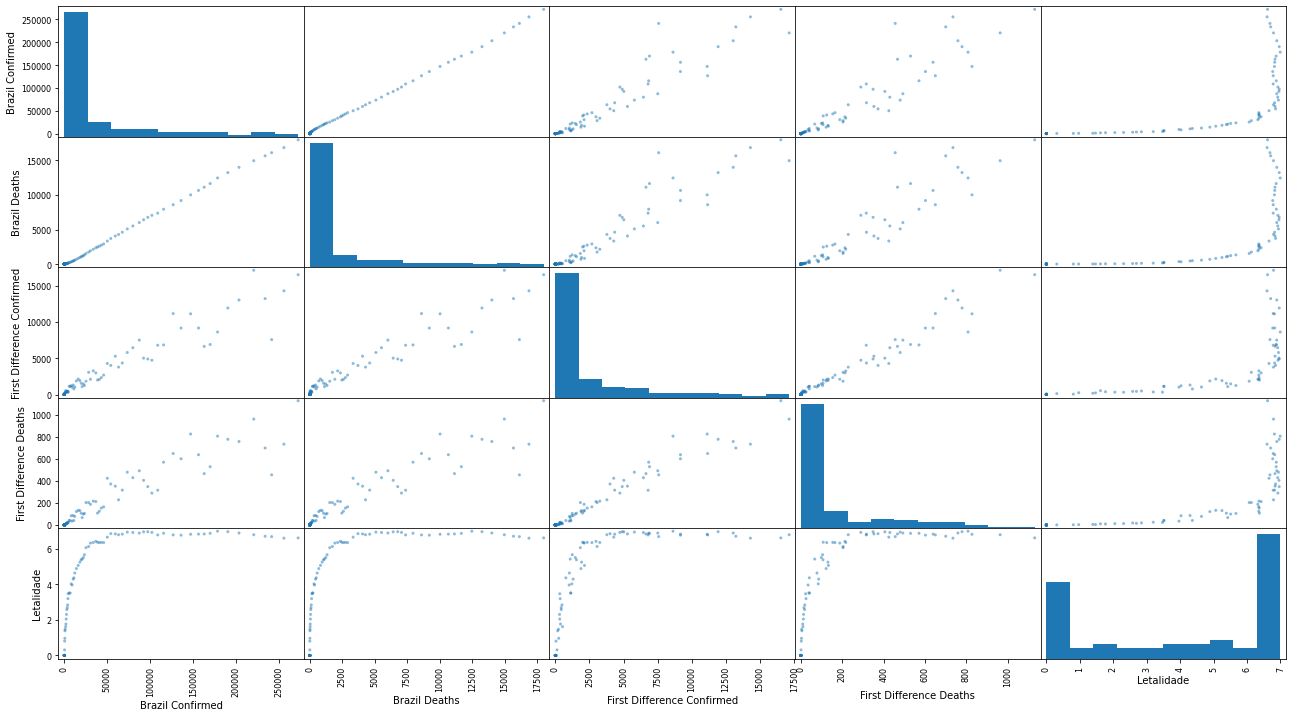

In [33]:
scatter_matrix(Brazil,figsize=(22,12));

Evolução da letalidade da doença, se estabilizando em 7% de todos que são diagnosticados positivos

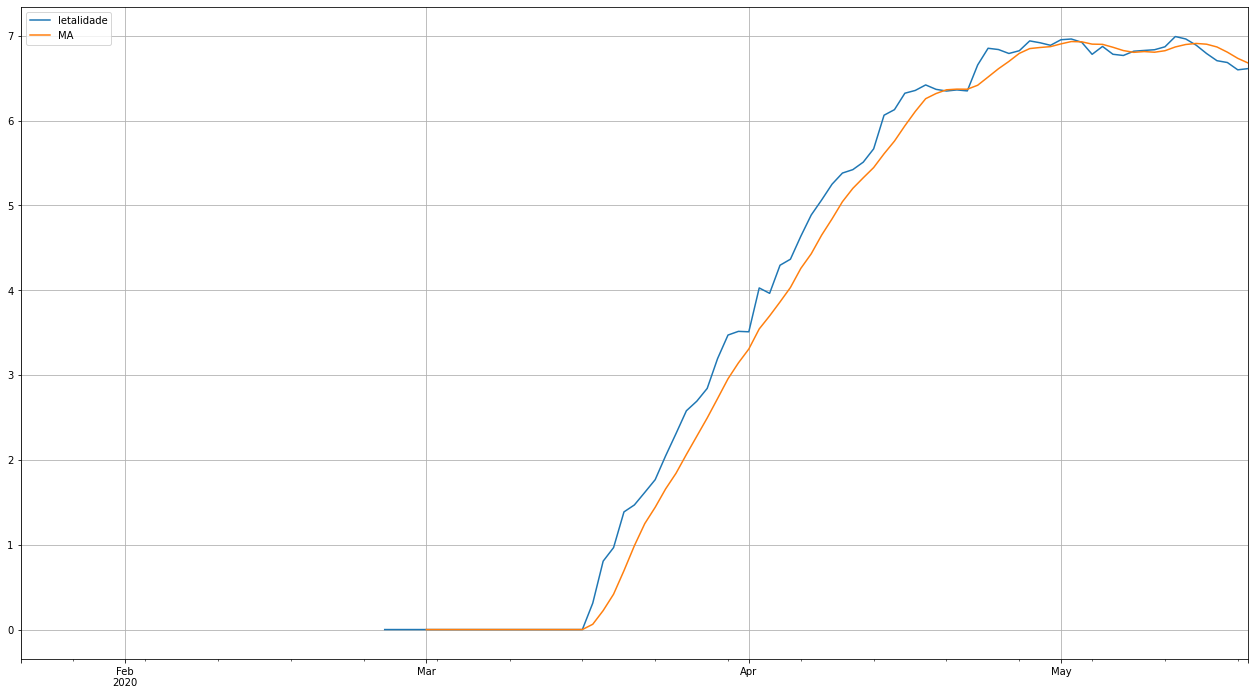

In [34]:
Brazil['Letalidade'].plot(figsize=(22,12), label = 'letalidade')
Brazil.rolling(window=5).mean()['Letalidade'].plot(label = 'MA',grid=True)
plt.legend()

Letalidade média de 6,61% nos ultimos 20 dias.

In [92]:
Brazil['Letalidade'].iloc[-20:].mean()

6.826967079778963

Comparação entre países

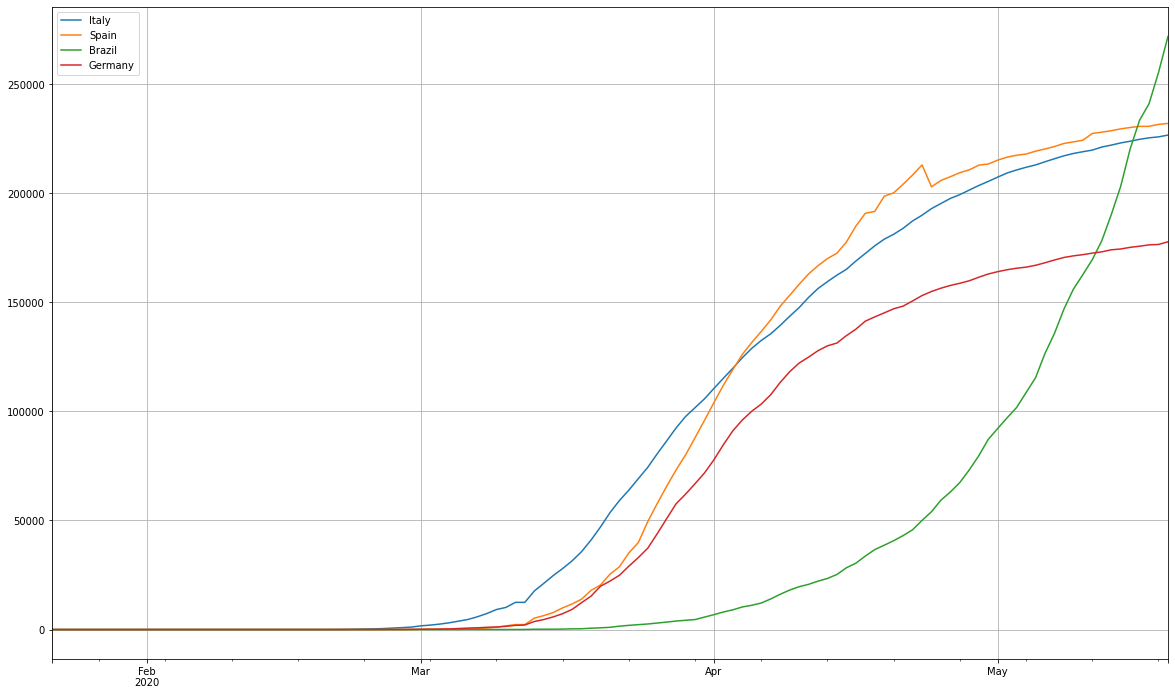

In [36]:
paises = ['Italy','Spain','Brazil','Germany']
comparador = confirmed_clean[paises]
comparador.plot(figsize = (20,12),grid=True)

Dados Estados Unidos

In [0]:
US = pd.concat([confirmed_clean['US'],deaths_clean['US']],axis=1)

In [0]:
colindex = ['US Confirmed','US Deaths']
US.columns = colindex

In [0]:
US['First Difference Confirmed'] = US['US Confirmed'] - US['US Confirmed'].shift(1)
US['First Difference Deaths'] = US['US Deaths'] - US['US Deaths'].shift(1)

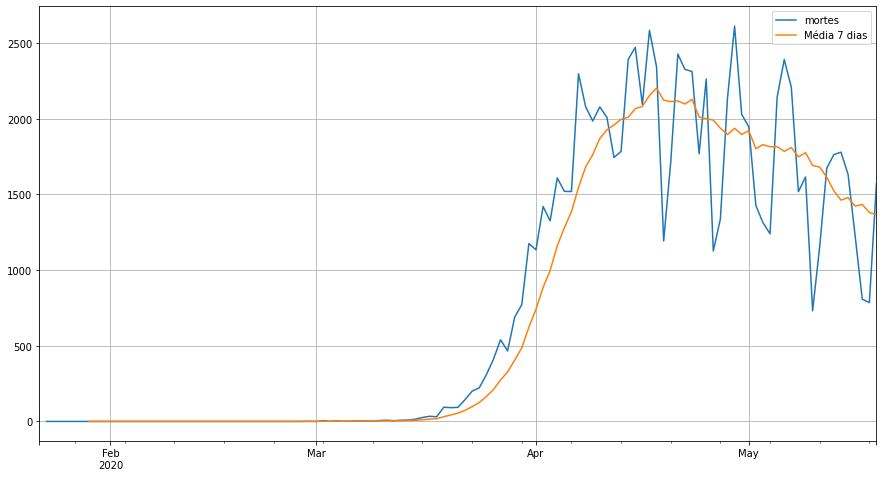

In [40]:
US['First Difference Deaths'].plot(figsize = (15,8),label='mortes')
US['First Difference Deaths'].rolling(7).mean().plot(grid = True, label = 'Média 7 dias',figsize = (15,8))
plt.legend()

Tendencias Brasil

In [0]:
BC_cycle, BC_trend = sm.tsa.filters.hpfilter(Brazil['Brazil Confirmed'])

In [0]:
Brazil['BC trend'] = BC_trend

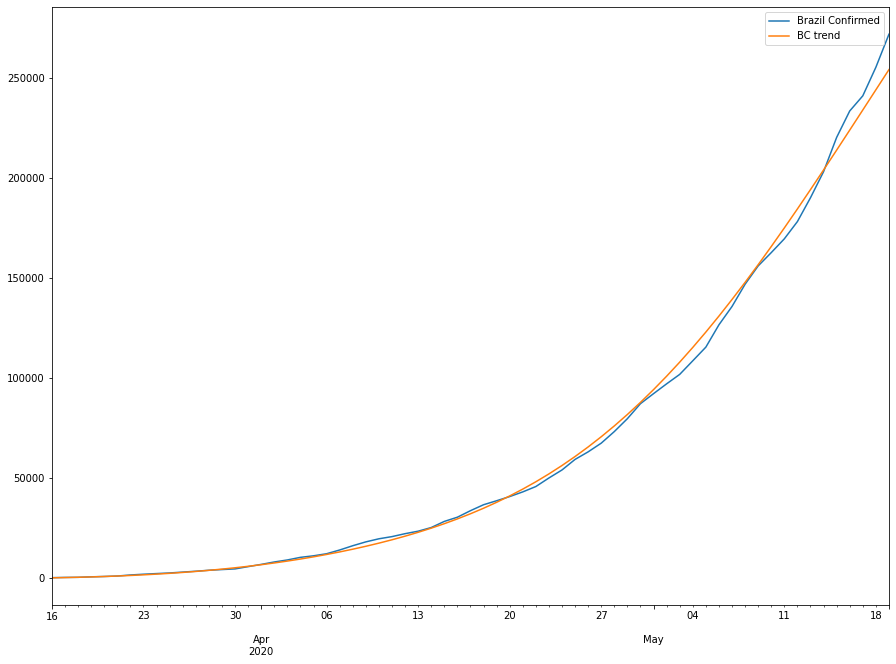

In [43]:
Brazil[['Brazil Confirmed','BC trend']]["2020-03-16":].plot(figsize=(15,11))

In [44]:
type(Brazil['BC trend']['2020-03-17':])

pandas.core.series.Series

In [0]:
from scipy.optimize import curve_fit

In [0]:
def func(x,a,b):
    return a*np.exp(b*x)

Fitting

In [0]:
inicio = '2020-04-10'
final = '2020-05-19'
yData = Brazil['BC trend'][inicio:final]
#yData = Brazil['Brazil Confirmed'][inicio:final]
xData = np.arange(1,len(yData)+1,1)
init_guess = [1,1]

popt,pcov = curve_fit(func,xData,yData,init_guess)

Tests

In [0]:
xfit = np.arange(1,60,0.01)
yfit = func(xfit,*popt)
yDataNew = Brazil['Brazil Confirmed'][inicio:]
xDataNew = np.arange(1,len(yDataNew)+1,1)

No grafico o dia 50 seria 07/05/2020 e o 60 17/05/2020

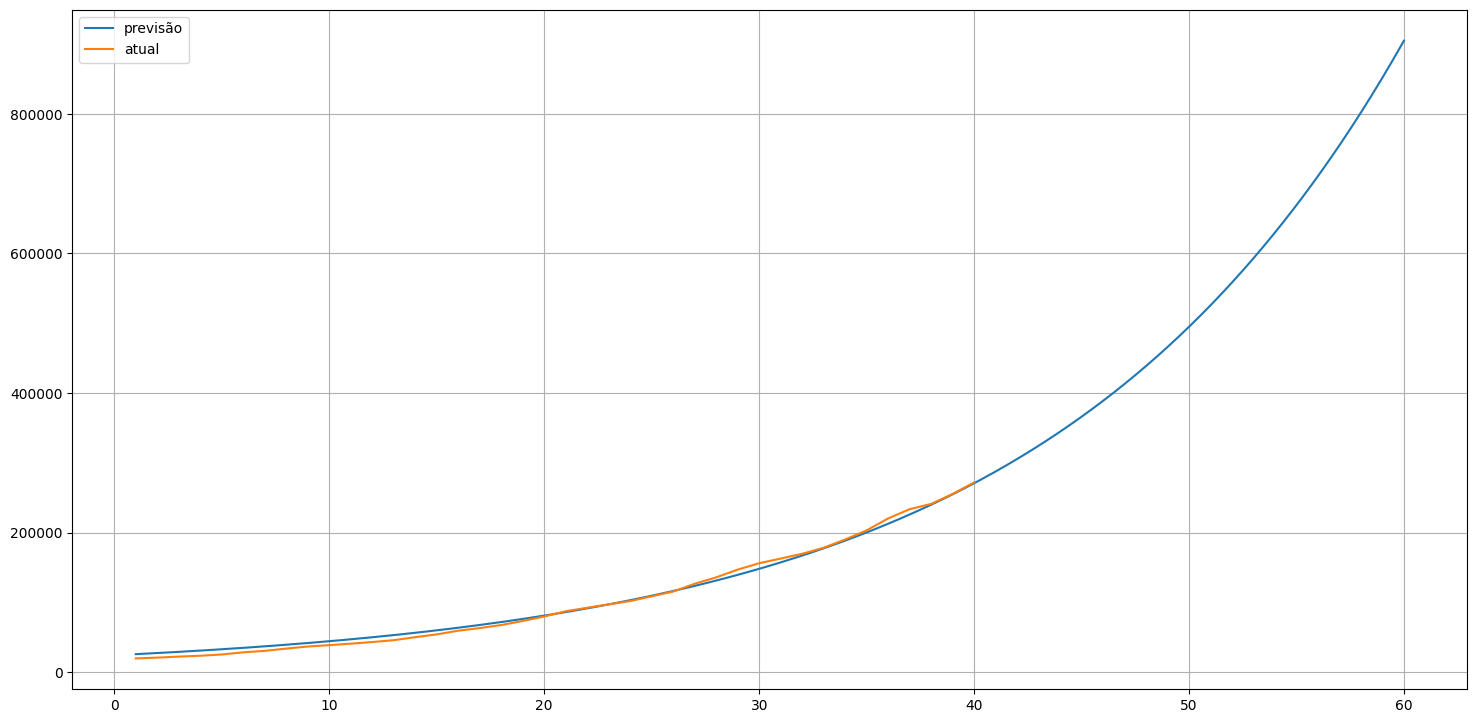

In [71]:
fig = plt.figure(figsize=(18,9),dpi=100)
plt.plot(xfit,yfit,label='previsão')
plt.plot(xDataNew,yDataNew, label = 'atual')
plt.legend()
plt.grid(True)

Regressão linear de casos confirmados vs mortes por dia a fim de verificar correlações

In [0]:
from scipy import stats

In [0]:
beta,alpha,r_value,p_value,std_err = stats.linregress(Brazil['First Difference Confirmed'].iloc[1:],Brazil['First Difference Deaths'].iloc[1:])

In [77]:
print("beta: {} e alpha: {}".format(beta,alpha))

beta: 0.06368067510859286 e alpha: 5.671013966951108


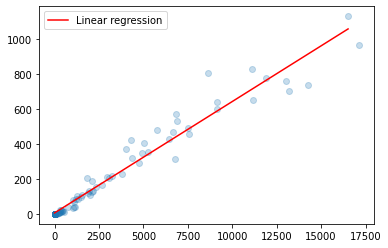

In [90]:
x = np.arange(0,Brazil['First Difference Confirmed'][-1],1)
y = x*beta + alpha
plt.plot(x,y, color = 'red', label = 'Linear regression')
plt.scatter(Brazil['First Difference Confirmed'],Brazil['First Difference Deaths'],alpha=0.25)
plt.legend()